<a href="https://colab.research.google.com/github/yasmensarhan27/23-Homework7G2/blob/main/Nacl_cube_Octagon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools
import scipy.optimize
ke2 = 197 / 137 # eV-nm   Coulomb force charge
alpha = 1.09e3  # eV      parameter of model
rho = 0.0321    # nm      parameter of model
b = 1.0         # eV      regular
c = 0.01        # nm

#Helpful solution to convert itertools combinations to numpy arrays here:
## https://stackoverflow.com/questions/33282369/convert-itertools-array-into-numpy-array
def cp(l):
    return np.fromiter(itertools.chain(*itertools.combinations(l,2)),dtype=int).reshape(-1,2)

class Cluster:
    def __init__(self, r_na, r_cl):
        '''
        Inputs the list of Na and Cl positions. Na has charge +1, Cl has -1.
        The array of ions itself does not change throughout the calculation, and
        neither do the charges. As such, we can just compute the combinations one time
        and refer to it throughout the calculation.
        '''
        self.positions = np.concatenate( (r_na,r_cl))
        self.charges = np.concatenate( [np.ones(r_na.shape[0]), np.full(r_cl.shape[0], -1)] )
        self.combs = cp(np.arange(self.charges.size))
        self.chargeprods = self.charges[self.combs][:,0] * self.charges[self.combs][:,1]
        self.rij = np.linalg.norm(self.positions[self.combs][:,0] - self.positions[self.combs][:,1], axis=1)

    def Vij(self):
        '''Calculate a numpy vector of all of the potentials of the combinations'''
        self.Vij_ = np.zeros_like(self.rij)
        pos = self.chargeprods>0
        neg = ~pos
        self.Vij_[pos] = ke2 / self.rij[pos] + b*(c/self.rij[pos])**12
        self.Vij_[neg] =-ke2 / self.rij[neg] + alpha*np.exp(-self.rij[neg]/rho) + b*(c/self.rij[neg])**12
        return self.Vij_

    def V(self):
        '''Total potential, which is a sum of the Vij vector'''
        return np.sum(self.Vij())

    def get_vals(self):
        '''Positions interpreted as a flat shape'''
        return np.reshape(self.positions, -1)

    def set_vals(self, vals ):
        '''Inputs flat shape of positions, used by __call__'''
        self.positions = vals.reshape(self.positions.shape)
        self.rij = np.linalg.norm(self.positions[self.combs][:,0] - self.positions[self.combs][:,1], axis=1)


    def __call__(self, vals):
        '''Function that  scipy.optimize.minimize will call'''
        self.set_vals(vals)
        return self.V()


In [ ]:
%%writefile Nacl.py

Writing Nacl.py


**Cubic Tetramer Configuration**

In [ ]:
import Nacl
a = 0.236 #nm

r_na = np.array( [ [a,0,0], [0, a, 0], [0, 0, a],[a, a, a] ] )
r_cl = np.array( [ [0, 0, 0],[a, a, 0],[a, 0, a],[0, a, a] ] )

cluster = Cluster(r_na, r_cl)
vals_init = cluster.get_vals()
print('initial Na positions:\n', r_na)
print('initial Cl positions:\n', r_cl)
print('initial positions flattened shape:\n', vals_init )
print('initial V  :', cluster.V() )

res = scipy.optimize.minimize( fun=cluster, x0=vals_init, tol=1e-3, method="BFGS")
cluster.set_vals(res.x)  # For some reason, "minimize" is not updating the class at the last iteration
print ("Final optimized cluster positions")
print(cluster.positions)
print("Final potential:", res.fun)

initial Na positions:
 [[0.236 0.    0.   ]
 [0.    0.236 0.   ]
 [0.    0.    0.236]
 [0.236 0.236 0.236]]
initial Cl positions:
 [[0.    0.    0.   ]
 [0.236 0.236 0.   ]
 [0.236 0.    0.236]
 [0.    0.236 0.236]]
initial positions flattened shape:
 [0.236 0.    0.    0.    0.236 0.    0.    0.    0.236 0.236 0.236 0.236
 0.    0.    0.    0.236 0.236 0.    0.236 0.    0.236 0.    0.236 0.236]
initial V  : -27.085601041071918
Final optimized cluster positions
[[ 0.24798716 -0.01202374 -0.01201888]
 [-0.01201652  0.2479902  -0.01202097]
 [-0.01202244 -0.01201737  0.2479891 ]
 [ 0.24799147  0.24798635  0.24798866]
 [-0.01202164 -0.01201863 -0.01201971]
 [ 0.24799229  0.24798508 -0.01202015]
 [ 0.24798636 -0.01202247  0.24798994]
 [-0.01201734  0.24799144  0.24798782]]
Final potential: -28.235830565026856


In [ ]:
%matplotlib inline

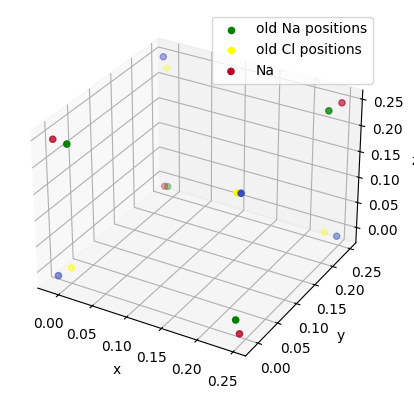

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

charges = cluster.charges
x,y,z = cluster.positions[:, 0], cluster.positions[:, 1], cluster.positions[:, 2]
#The yellow dots are for Cl, the green dots are for Na.
old_na_x= r_na[:,0]
old_na_y= r_na[:,1]
old_na_z=r_na[:,2]
old_cl_x=r_cl[:,0]
old_cl_y=r_cl[:,1]
old_cl_z=r_cl[:,2]
ax.scatter(old_na_x,old_na_y,old_na_z, c='green', label='old Na positions')
ax.scatter(old_cl_x,old_cl_y,old_cl_z, c='yellow', label='old Cl positions')
#The blue dots are Cl, the red dots are Na.

ax.scatter( x,y,z, c=charges, cmap='coolwarm', label='Na')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
plt.show()

**Octagon Configuration**

initial Na positions:
 [[ 0.    0.    0.  ]
 [ 1.67  4.03  0.  ]
 [ 5.7   2.36  0.  ]
 [ 4.03 -1.67  0.  ]]
initial Cl positions:
 [[ 0.    2.36  0.  ]
 [ 5.7   0.    0.  ]
 [ 1.67 -1.67  0.  ]
 [ 4.03  4.03  0.  ]]
initial positions flattened shape:
 [ 0.    0.    0.    1.67  4.03  0.    5.7   2.36  0.    4.03 -1.67  0.
  0.    2.36  0.    5.7   0.    0.    1.67 -1.67  0.    4.03  4.03  0.  ]
initial V  : -3.3215578092527043
Final optimized cluster positions
[[ 2.56407959e+00  1.03504747e+00  1.36347216e-03]
 [ 2.70505151e+00  1.46586973e+00 -1.65505958e-04]
 [ 3.13587185e+00  1.32489682e+00 -1.37497940e-03]
 [ 2.99490057e+00  8.94076526e-01  1.55584602e-04]
 [ 2.54534093e+00  1.27965565e+00  8.49570639e-04]
 [ 3.15461259e+00  1.08028936e+00 -8.60051488e-04]
 [ 2.75029519e+00  8.75335704e-01  1.07645761e-03]
 [ 2.94965755e+00  1.48460960e+00 -1.08737454e-03]]
Final potential: -27.78243508220967


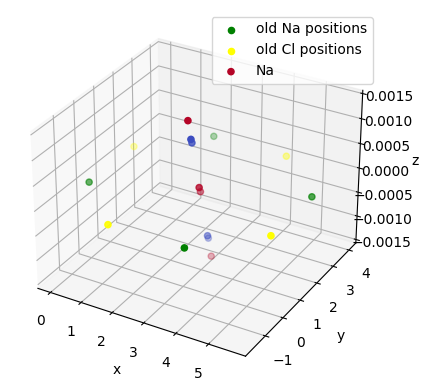

In [23]:
import Nacl

r_na = np.array( [ [0, 0, 0], [1.67,4.03,0], [5.7, 2.36, 0],[4.03, -1.67, 0] ] )
r_cl = np.array( [ [0, 2.36, 0],[5.7, 0, 0],[1.67, -1.67, 0],[4.03, 4.03, 0] ] )

cluster = Cluster(r_na, r_cl)
vals_init = cluster.get_vals()
print('initial Na positions:\n', r_na)
print('initial Cl positions:\n', r_cl)
print('initial positions flattened shape:\n', vals_init )
print('initial V  :', cluster.V() )

res = scipy.optimize.minimize( fun=cluster, x0=vals_init, tol=1e-3, method="BFGS")
cluster.set_vals(res.x)  # For some reason, "minimize" is not updating the class at the last iteration
print ("Final optimized cluster positions")
print(cluster.positions)
print("Final potential:", res.fun)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

charges = cluster.charges
x,y,z = cluster.positions[:, 0], cluster.positions[:, 1], cluster.positions[:, 2]
#The yellow dots are for Cl, the green dots are for Na.
old_na_x= r_na[:,0]
old_na_y= r_na[:,1]
old_na_z=r_na[:,2]
old_cl_x=r_cl[:,0]
old_cl_y=r_cl[:,1]
old_cl_z=r_cl[:,2]
ax.scatter(old_na_x,old_na_y,old_na_z, c='green', label='old Na positions')
ax.scatter(old_cl_x,old_cl_y,old_cl_z, c='yellow', label='old Cl positions')
#The blue dots are Cl, the red dots are Na.

ax.scatter( x,y,z, c=charges, cmap='coolwarm', label='Na')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
plt.show()